In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://mirrors.sonic.net/apache/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xzf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark


import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"


import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [2]:
from pyspark import SparkFiles   #ficheros del cluster (ordenadores) se pueden pasar por url
spark.sparkContext.addFile('https://cnecovid.isciii.es/covid19/resources/casos_tecnica_ccaa.csv') #guarda como nombre la ultima parte de la url
df = spark.read.options(inferSchema='True', header='True').csv(SparkFiles.get('casos_tecnica_ccaa.csv'))

In [3]:
df.describe().toPandas() #como el describe tiene pocos elementos podemos visualizarlo con pandas

,summary,ccaa_iso,fecha,num_casos,num_casos_prueba_pcr,num_casos_prueba_test_ac,num_casos_prueba_ag,num_casos_prueba_elisa,num_casos_prueba_desconocida
0,count,12388,12388,12388,12388,12388,12388,12388,12388
1,mean,None,None,402.01913141750083,291.8530836293187,0.3862608976428802,103.67371649983855,0.6136583790765257,5.492412011624152
2,stddev,None,None,830.4581772042465,581.8330408834207,3.4891653403534786,322.24513888648914,4.0327328758035765,45.885623638200556
3,min,AN,2020-01-01,0,0,0,0,0,0
4,max,VC,2021-10-13,9836,6446,96,5732,70,942


In [4]:
df.printSchema()

root
 |-- ccaa_iso: string (nullable = true)
 |-- fecha: string (nullable = true)
 |-- num_casos: integer (nullable = true)
 |-- num_casos_prueba_pcr: integer (nullable = true)
 |-- num_casos_prueba_test_ac: integer (nullable = true)
 |-- num_casos_prueba_ag: integer (nullable = true)
 |-- num_casos_prueba_elisa: integer (nullable = true)
 |-- num_casos_prueba_desconocida: integer (nullable = true)



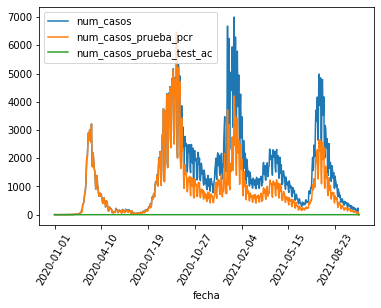

In [9]:
df.filter("ccaa_iso ='MD'").count() #devuelve 652, es algo que puede manejar Pandas, por eso podemos visualizarlo con un plot
df.filter("ccaa_iso ='MD'").toPandas()\
    .plot(x='fecha', y=['num_casos', 'num_casos_prueba_pcr', 'num_casos_prueba_test_ac'], rot=60)

In [10]:
from pyspark.sql.functions import col
data = df.filter(col('ccaa_iso').isin(['MD', 'CM', 'CT', 'CL', 'AN'])).sample(fraction=0.9).toPandas() #como son tantos datos no podemos visualizarlo. Por eso hacemos un sample (porcion de datos)

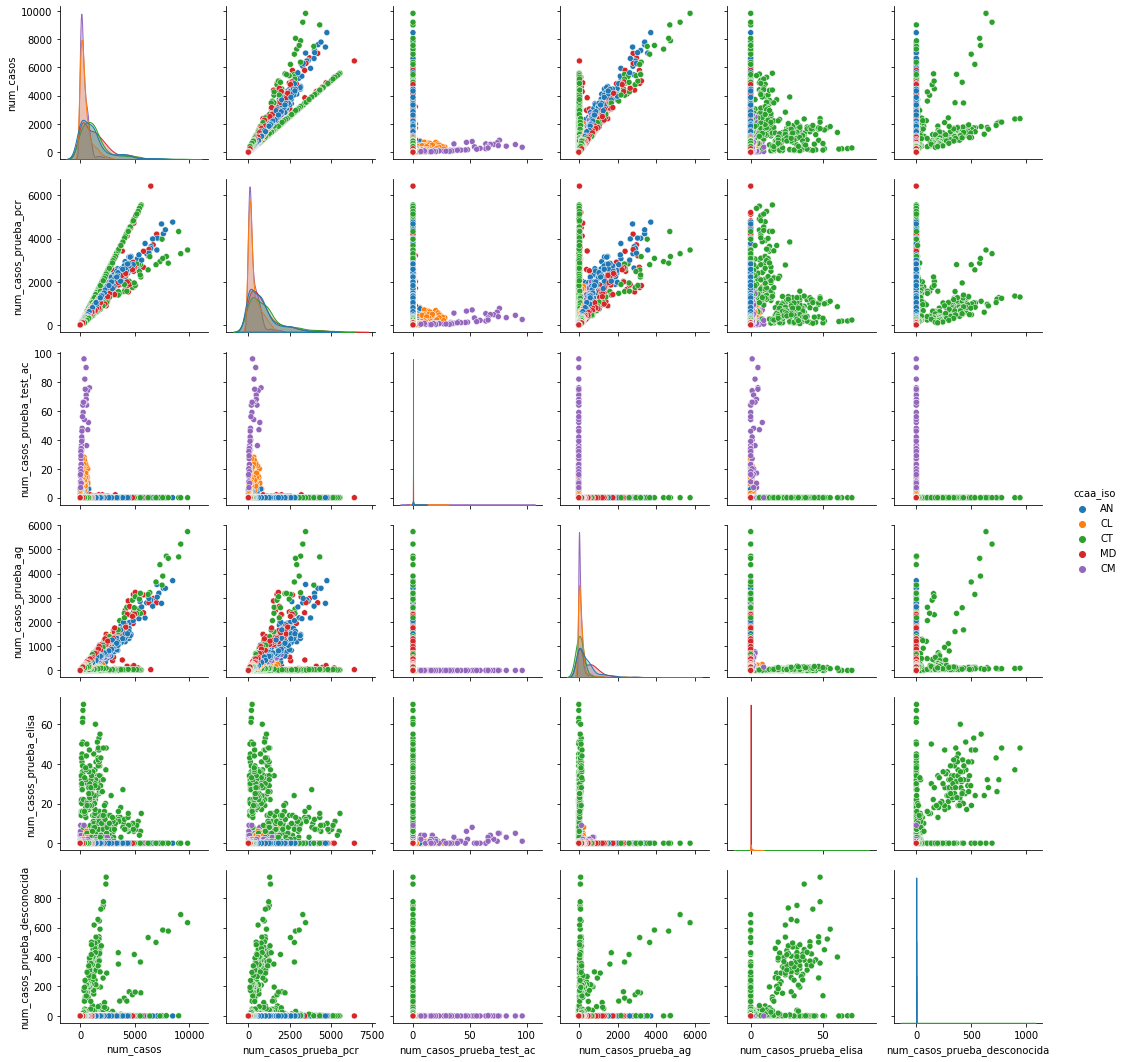

In [11]:
import seaborn as sns
sns.pairplot(data=data, hue='ccaa_iso') #pairplot = matriz que mira las correlaciones cruzadas de todos los elementos (columnas)
                                        #hue = color

In [12]:
df.corr('num_casos', 'num_casos_prueba_pcr')

0.9496428229825774

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


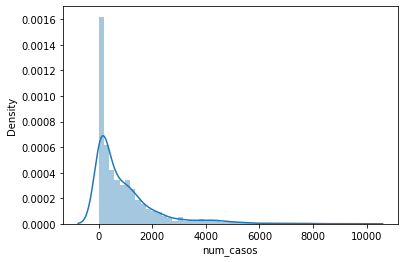

In [13]:
sns.distplot(data.num_casos) #printear solo la densidad de probabilidad

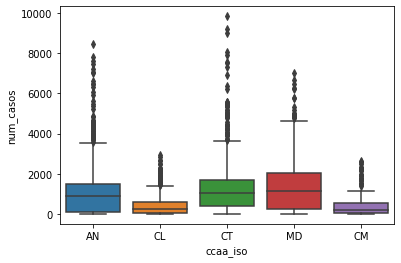

In [14]:
sns.boxplot(x=data.ccaa_iso, y=data.num_casos)

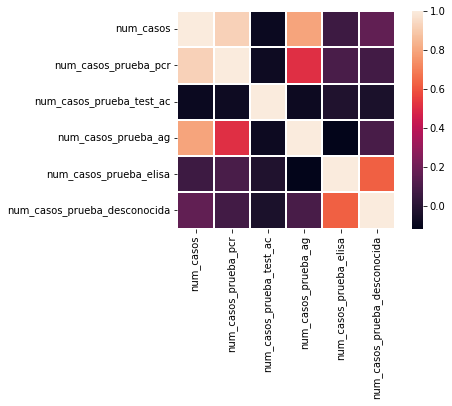

In [17]:
sns.heatmap(data.corr(), linewidths=1, square=True)

In [18]:
data = df.filter(col('ccaa_iso').isin(['MD', 'CM', 'CT', 'CL', 'AN'])).sample(fraction=0.9)
data.columns

['ccaa_iso',
 'fecha',
 'num_casos',
 'num_casos_prueba_pcr',
 'num_casos_prueba_test_ac',
 'num_casos_prueba_ag',
 'num_casos_prueba_elisa',
 'num_casos_prueba_desconocida']

In [20]:
from pyspark.ml.feature import VectorAssembler #tengo que meter en una unica columna todos los campos con los que vaya a trabajar. Esta columna Spark la convierte en un Vector NUNCA METER UN BUCLE!!
assembler = VectorAssembler( #Juntar columnas en una unica colmna y ensamblarlo como un vector
    inputCols=['num_casos_prueba_pcr', 'num_casos_prueba_test_ac', 'num_casos_prueba_ag',
               'num_casos_prueba_elisa', 'num_casos_prueba_desconocida'],
    outputCol='all_features') #Mete ese vector en una columna llamada "all_features"
final_data = assembler.transform(data)
final_data.show(5) #Podemos ver como en la ultima columna estan todos los elementos guardados (5,[],[]) vector de 5 elementos   (5,[0],[1.0]) vector de 5 elementos con un 1 en alguna columna

+--------+----------+---------+--------------------+------------------------+-------------------+----------------------+----------------------------+-------------+
|ccaa_iso|     fecha|num_casos|num_casos_prueba_pcr|num_casos_prueba_test_ac|num_casos_prueba_ag|num_casos_prueba_elisa|num_casos_prueba_desconocida| all_features|
+--------+----------+---------+--------------------+------------------------+-------------------+----------------------+----------------------------+-------------+
|      AN|2020-01-01|        0|                   0|                       0|                  0|                     0|                           0|    (5,[],[])|
|      CL|2020-01-01|        0|                   0|                       0|                  0|                     0|                           0|    (5,[],[])|
|      CM|2020-01-01|        0|                   0|                       0|                  0|                     0|                           0|    (5,[],[])|
|      CT|2020-0

In [21]:
from pyspark.ml.feature import PCA
pca = PCA(k=3, inputCol='all_features', outputCol='features') #resume el contenido
pcaModel = pca.fit(final_data) #fit: crea un modelo para configurar los datos

output = pcaModel.transform(final_data) #el output ezs un dataframe que solo contiene las columnas(componentes) mas importantes. Con tarnsform se crea el resultado
#all_features tiene 5 elementos y el features tiene solo 3 (k) las mas importantes

In [22]:
output.toPandas()

,ccaa_iso,fecha,num_casos,num_casos_prueba_pcr,num_casos_prueba_test_ac,num_casos_prueba_ag,num_casos_prueba_elisa,num_casos_prueba_desconocida,all_features,features
0,AN,2020-01-01,0,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0)","[0.0, 0.0, 0.0]"
1,CL,2020-01-01,0,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0)","[0.0, 0.0, 0.0]"
2,CM,2020-01-01,0,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0)","[0.0, 0.0, 0.0]"
3,CT,2020-01-01,0,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0)","[0.0, 0.0, 0.0]"
4,MD,2020-01-01,1,1,0,0,0,0,"(1.0, 0.0, 0.0, 0.0, 0.0)","[-0.9131696002442015, -0.40754764936074844, -0..."
...,...,...,...,...,...,...,...,...,...,...
2918,MD,2021-10-12,37,26,0,11,0,0,"(26.0, 0.0, 11.0, 0.0, 0.0)","[-28.224754449591284, -0.5516871977665367, -0...."
2919,AN,2021-10-13,0,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0)","[0.0, 0.0, 0.0]"
2920,CL,2021-10-13,0,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0)","[0.0, 0.0, 0.0]"
2921,CT,2021-10-13,0,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0)","[0.0, 0.0, 0.0]"


In [23]:
pcaModel.explainedVariance #la priemra explica el 81% d ela varianza, la segunda el 18, etc

DenseVector([0.812, 0.1809, 0.007])

In [24]:
pcaModel.pc.toArray() #Combinacion lineal de los distintos elementos

array([[-9.13169600e-01, -4.07547649e-01, -4.81140961e-03],
       [ 5.65199452e-04, -5.89045997e-04, -2.31784035e-03],
       [-4.07485895e-01,  9.13141062e-01, -1.06426566e-02],
       [-5.12805107e-04, -3.76159489e-03,  5.80892861e-02],
       [-8.71460135e-03,  7.98856802e-03,  9.98240375e-01]])